# Clone the git

In [ ]:
!git clone https://github.com/Ikromov247/capstone2023.git

Cloning into 'capstone2023'...
remote: Enumerating objects: 65, done.
remote: Total 65 (delta 0), reused 0 (delta 0), pack-reused 65
Receiving objects: 100% (65/65), 28.23 MiB | 13.74 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Paths to the file

In [ ]:
file_path1 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(101지점).xlsx'
file_path2 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(102지점).xlsx'
file_path3 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(103지점).xlsx'
file_path4 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(104지점).xlsx'
file_path5 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(105지점).xlsx'
file_path6 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(106지점).xlsx'
file_path7 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(107지점).xlsx'
file_path8 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(108지점).xlsx'
file_path9 = '/content/drive/MyDrive/Blue_sky_dataset_2/CapstoneProject_Dataset/2022-12-01-2023-07-01(109지점).xlsx'

# Read the File

In [ ]:
#read the file and convert the datatime into the appropriate format
df = pd.read_excel(file_path9, parse_dates=['시간'])

# choose the time span after 15000 datapoints
df = df.iloc[14500:, :]

#get rid of the last row because it is irrelevant datapoint
df.drop(df.iloc[-1].name, axis=0, inplace=True)

# drop 지점 and atm columns since there is no use in it
df.drop(['지점', 'atm'], axis=1, inplace=True)

In [ ]:
# Circular encoding of winddirection
# Function to map wind direction to degrees
def map_direction_to_angle(direction):
    direction_map = {
        '남': 180,      # South
        '남남서': 202.5, # South-Southwest
        '남남동': 157.5, # South-Southeast
        '남서': 225,    # Southwest
        '서남서': 247.5, # West-Southwest
        '서': 270,      # West
        '북북서': 337.5, # North-Northwest
        '북': 0,        # North
        '북서': 315,    # Northwest
        '북북동': 22.5,  # North-Northeast
        '북동': 45,     # Northeast
        '동북동': 67.5,  # East-Northeast
        '서북서': 292.5, # West-Northwest
        '동': 90,       # East
        '동남동': 112.5, # East-Southeast
        '남동': 135,    # Southeast
        '-': np.nan    # Undefined or missing data
    }
    return direction_map.get(direction, np.nan)

# Apply the mapping to the dataframe
df['winddirection_angle'] = df['winddirection'].apply(map_direction_to_angle)

# Convert angles to radians for sine and cosine transformation
df['winddirection_sin'] = np.sin(np.deg2rad(df['winddirection_angle']))
df['winddirection_cos'] = np.cos(np.deg2rad(df['winddirection_angle']))

# Display the first few rows of the modified dataframe
df[['winddirection', 'winddirection_angle', 'winddirection_sin', 'winddirection_cos']].head()

,winddirection,winddirection_angle,winddirection_sin,winddirection_cos
14500,북,0.0,0.000000e+00,1.000000
14501,남,180.0,1.224647e-16,-1.000000
14502,북,0.0,0.000000e+00,1.000000
14503,북서,315.0,-7.071068e-01,0.707107
14504,북북동,22.5,3.826834e-01,0.923880


# Heat Map

<ipython-input-6-a9ad0798eac9>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


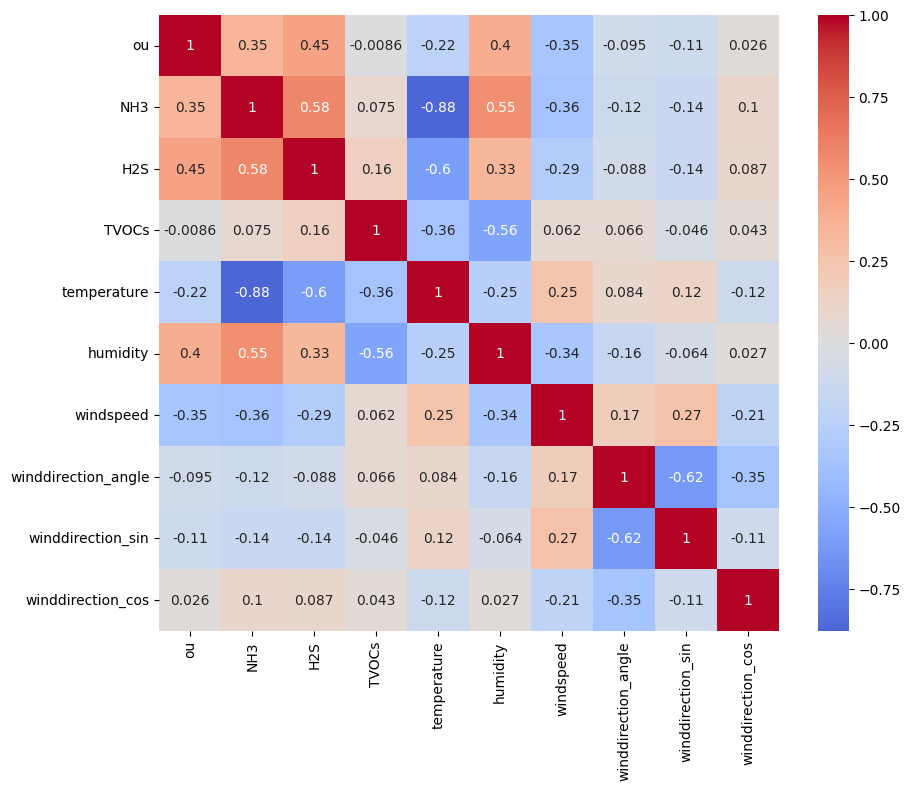

In [ ]:
#heat-map

correlation = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.show()

# Describing the dataset

In [ ]:
df.describe()

,ou,NH3,H2S,TVOCs,temperature,humidity,windspeed,winddirection_angle,winddirection_sin,winddirection_cos
count,41392.000000,41392.000000,41392.000000,41392.00000,41392.000000,41392.000000,41392.000000,41392.000000,41392.000000,41392.000000
mean,4.426389,0.683602,0.011506,0.06929,14.582917,6.243598,0.700971,147.243670,-0.090433,0.160177
std,1.718397,0.120421,0.021931,0.02576,9.226810,2.311293,0.819105,118.222281,0.580171,0.793467
min,0.000000,0.000000,0.000000,0.00000,-7.600000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,3.200000,0.600000,0.000000,0.05500,7.400000,4.600000,0.200000,0.000000,-0.707107,-0.707107
50%,4.000000,0.695000,0.000000,0.08400,15.500000,6.500000,0.400000,157.500000,0.000000,0.382683
75%,5.300000,0.787000,0.017000,0.08700,21.800000,8.300000,1.000000,270.000000,0.382683,1.000000
max,45.100000,0.927000,0.362000,0.18600,36.200000,9.800000,9.400000,337.500000,1.000000,1.000000


# Getting rid of outliers

In [ ]:
# Function to remove outliers

def remove_outliers_IQR(data, column):
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the upper and lower bounds
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    # Identify outliers
    outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)]

    # Remove outliers from the data
    data_filtered = data.drop(outliers.index, axis=0, inplace=True)

    return data_filtered

print('The length of the df before: ', len(df))
remove_outliers_IQR(df, 'ou')
# remove_outliers_IQR(df, 'H2S')
print('The length of the df after: ', len(df))

The length of the df before:  40892
The length of the df after:  39183


In [ ]:
#Getting rid using thresholds

df.drop(df[df["ou"]>10].index, inplace=True)
# df.drop(df[df["TVOCs"]>0.11].index, inplace=True)
# df.drop(df[df["NH3"]<0.3].index, inplace=True)
# df.drop(df[df["H2S"]>0.1].index, inplace=True)

# Data normalization

In [ ]:
# Normalize the data
df.drop(['시간', 'winddirection'], axis=1, inplace=False).apply(lambda x: x / np.linalg.norm(x))

,ou,NH3,H2S,TVOCs,temperature,humidity,windspeed
15000,0.008435,0.006407,0.013591,0.006236,-0.001538,0.005928,0.000914
15001,0.008227,0.006400,0.013997,0.006169,-0.001538,0.005854,0.000000
15002,0.008435,0.006407,0.013997,0.006236,-0.001595,0.005854,0.001829
15003,0.008435,0.006407,0.014200,0.006236,-0.001595,0.005928,0.000914
15004,0.008435,0.006407,0.013997,0.006169,-0.001567,0.005928,0.000000
...,...,...,...,...,...,...,...
55887,0.004478,0.004400,0.000000,0.001475,0.007037,0.006447,0.000000
55888,0.004374,0.004443,0.000000,0.001475,0.007008,0.006447,0.000000
55889,0.004478,0.004436,0.000000,0.001475,0.007008,0.006521,0.000000
55890,0.004270,0.004450,0.000000,0.001475,0.006980,0.006521,0.000000


# Visuzliazing the boxplots of the four main features

In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first boxplot
axs = axs.ravel()

axs[0].boxplot(df['NH3'])
axs[0].set_title('NH3')

# Plot the second boxplot
axs[1].boxplot(df['H2S'])
axs[1].set_title('H2S')

# Plot the third boxplot
axs[2].boxplot(df['TVOCs'])
axs[2].set_title('TVOCs')

axs[3].boxplot(df['ou'])
axs[3].set_title('ou')

# Add labels and a title to the entire figure
plt.xlabel("Categories")
plt.ylabel("Values")
plt.suptitle("Separate Boxplots for Multiple Categories")

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()



# Time series graph


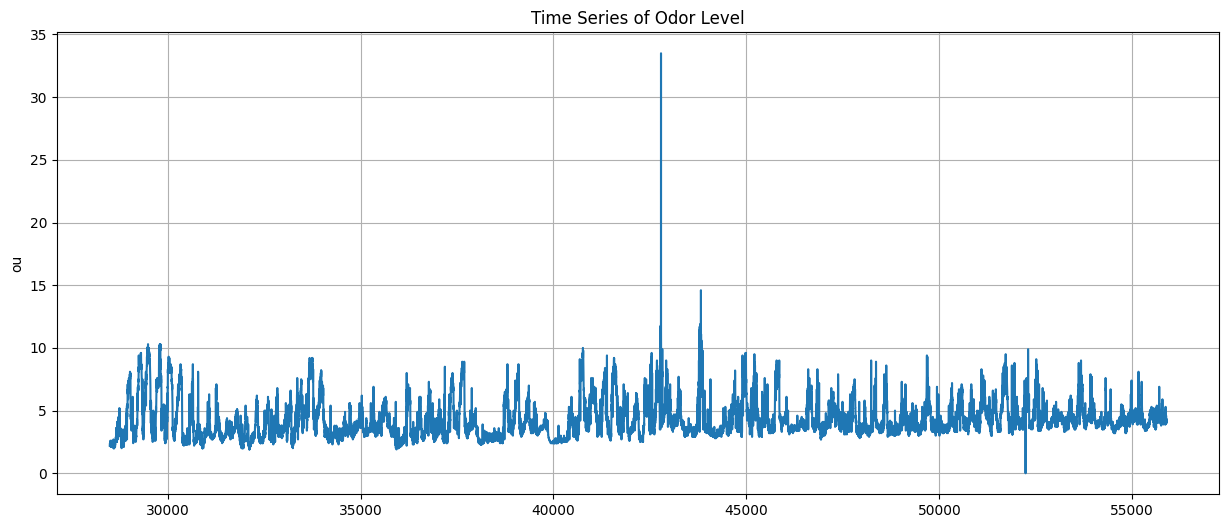

In [ ]:
plt.figure(figsize=(15, 6))
df['ou'].plot(title='Time Series of Odor Level')
plt.ylabel('ou')
plt.grid(True)
plt.show()

# Time series graph of two or more fearures

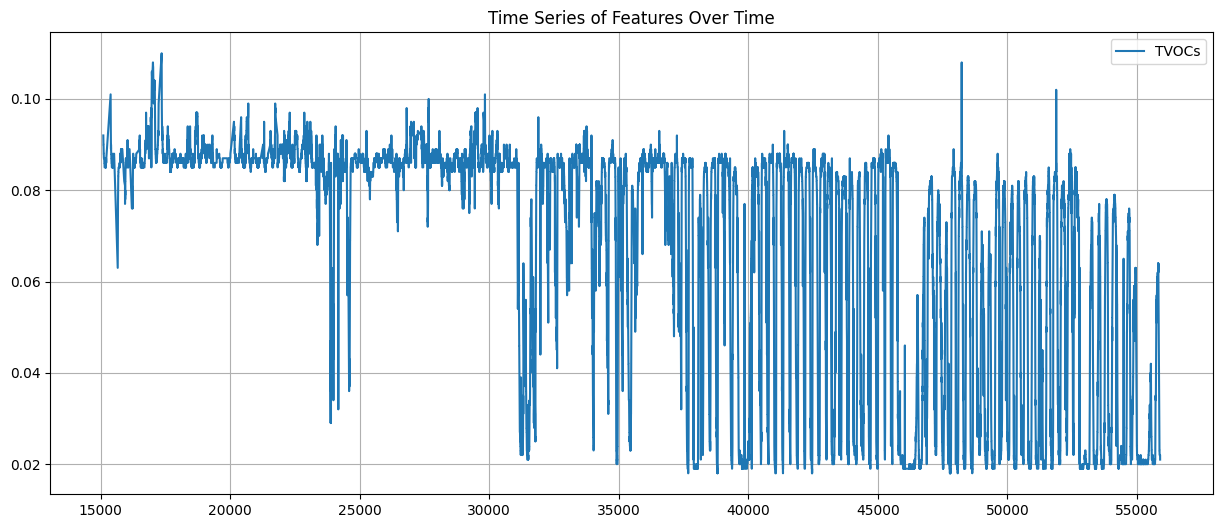

In [ ]:
# time-series graph for two or more features

plt.figure(figsize=(15, 6))
for column in df.columns:
    if column not in ['시간', 'NH3', 'ou', 'temperature', 'pozip', 'humidity', 'H2S',
       'winddirection', 'windspeed']:  # Excluding the target variable or others as needed
        df[column].plot(label=column)

# df["ou"].plot(label="ou")
plt.title('Time Series of Features Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Time Series with different time intervals

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# Sample time series data (replace this with your own data)
# Assuming 'timestamps' is a list of datetime objects with 5-minute intervals
# For example: timestamps = pd.date_range(start='2023-01-01', end='2023-10-12', freq='5T')
# timestamps = pd.date_range(start='2022-12-12 16:33:00', end='2023-10-12', freq='5T')
timestamps = df["시간"][:]
data = df["ou"] # Replace this with your actual data

# Create a DataFrame with timestamps and data
df = pd.DataFrame({'Timestamp': timestamps, 'Data': data})

# Set the Timestamp column as the index
df.set_index('Timestamp', inplace=True)

# Plotting the data
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Data'])

# Formatting x-axis to show only months
plt.xticks(df.resample('M').mean().index, [x.strftime('%B') for x in df.resample('M').mean().index])
# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Data Values')
plt.title('Time Series Data with Monthly X-Ticks')

KeyError: ignored

# Plotting Histograms of the four main features

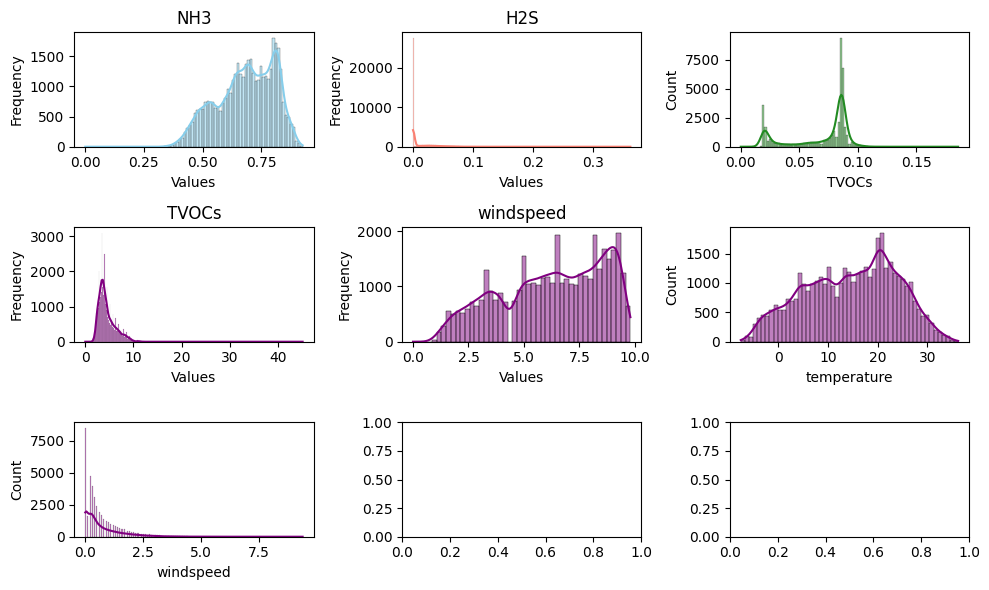

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 6))

# Plot the first histogram (top-left)
sns.histplot(df['NH3'], kde=True, color='skyblue', ax=axs[0, 0])
axs[0, 0].set_xlabel("Values")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].set_title("NH3")

# Plot the second histogram (top-right)
sns.histplot(df['H2S'], kde=True, color='salmon', ax=axs[0, 1])
axs[0, 1].set_xlabel("Values")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].set_title("H2S")

# Plot the third histogram (bottom-left)
sns.histplot(df['TVOCs'], kde=True, color='forestgreen', ax=axs[0, 2])
axs[1, 0].set_xlabel("Values")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].set_title("TVOCs")

# Plot the fourth histogram (bottom-right)
sns.histplot(df['ou'], kde=True, color='purple', ax=axs[1, 0])
axs[1, 1].set_xlabel("Values")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("ou")

# Plot the fourth histogram (bottom-right)
sns.histplot(df['humidity'], kde=True, color='purple', ax=axs[1, 1])
axs[1, 1].set_xlabel("Values")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("humidity")

# Plot the fourth histogram (bottom-right)
sns.histplot(df['temperature'], kde=True, color='purple', ax=axs[1, 2])
axs[1, 1].set_xlabel("Values")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("temperature")

# Plot the fourth histogram (bottom-right)
sns.histplot(df['windspeed'], kde=True, color='purple', ax=axs[2, 0])
axs[1, 1].set_xlabel("Values")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("windspeed")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


#Visualizing feature importance using Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the regressor to your data
regressor.fit(df[['NH3', 'H2S', 'TVOCs', 'temperature', 'humidity', 'windspeed', 'winddirection_angle', 'winddirection_sin', 'winddirection_cos']], df['ou'])


# Get feature importances from the trained regressor
feature_importances = regressor.feature_importances_


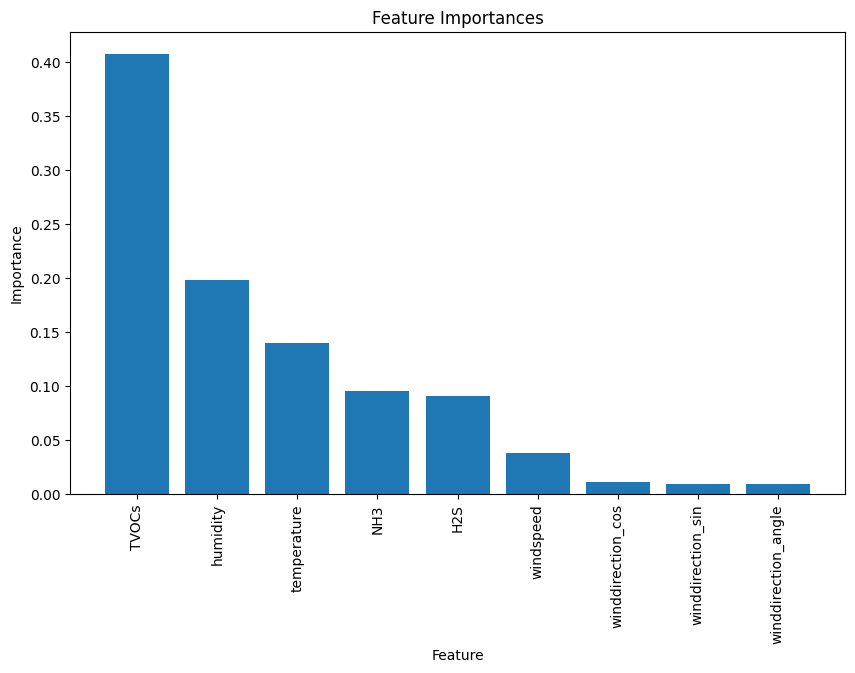

In [ ]:
# Sort features by importance in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the names of the features (assuming they are in a list or DataFrame)
feature_names = df[['NH3', 'H2S', 'TVOCs', 'temperature', 'humidity', 'windspeed', 'winddirection_angle', 'winddirection_sin', 'winddirection_cos']].columns  # Change this to your actual feature names

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()
